## Подготовка данных

### Данные от заказчика

Импортируем необходимые библиотеки, модели. Загрузим данные и сделам обзор данных.

In [1]:
!pip install financialanalysis
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import financialanalysis as fa
import time

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import catboost as cb
import lightgbm as lgb

In [3]:
df_original = pd.read_csv('/content/autos.csv')

Описание от Заказчика
**Признаки:**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя


**Целевой признак:**
- `Price` — цена (евро)

In [4]:
df_original.head().T

,0,1,2,3,4
DateCrawled,2016-03-24 11:52:17,2016-03-24 10:58:45,2016-03-14 12:52:21,2016-03-17 16:54:04,2016-03-31 17:25:20
Price,480,18300,9800,1500,3600
VehicleType,NaN,coupe,suv,small,small
RegistrationYear,1993,2011,2004,2001,2008
Gearbox,manual,manual,auto,manual,manual
Power,0,190,163,75,69
Model,golf,NaN,grand,golf,fabia
Kilometer,150000,125000,125000,150000,90000
RegistrationMonth,0,5,8,6,7
FuelType,petrol,gasoline,gasoline,petrol,gasoline


Очевидно, что некоторые столбцы лишние, то есть не несут ни какой смысловой нагрузки для задачи определения цены автомобиля. Некоторые столбцы предоставляют половинчатую информацию. Поэтому предлагается сделать следующие преобразования:
1. Удалить столбцы: `DateCrawled`, `PostalCode`, `LastSeen`. Так как Почтовый код и данные даты не влияют на стоимость автомобиля.
2. Объединить стобцы `RegistrationYear` & `RegistrationMonth` в один `RegistrationDate`

Далее необходимо будет подготовить данные:
- изменить названия столбцов
- заполнить пропуски
- удалить дубликаты, если они есть
- преобразовать данные
- разбить на тренировочную и тестовую выборки

Колонки будем рассматривать в следующем порядке значимости: **data, brand, model, vehicle_type, fuel_type, power, kilometer, not_repaired, number_of_pictures, price**

### EDA

#### data columns

In [5]:
df = df_original.drop(['DateCrawled', 'PostalCode', 'LastSeen'], axis=1)

Меняем названия столбцов в таблице

In [6]:
df.columns = ['price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'kilometer', 'registration_month', 'fuel_type', 'brand', 'not_repaired',
       'date_created', 'number_of_pictures']

Объеденим столбцы Регистрации

In [7]:
df['registration_month'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

Но сначала избавимся от нулевых значений, так как не бывает 0 месяца, заменим данный параметр месяцем **1**

In [8]:
df['registration_month'] = df['registration_month'].replace(0, 1)

In [9]:
df[['registration_year', 'registration_month']].isna().sum()

registration_year     0
registration_month    0
dtype: int64

In [10]:
df['registration_year'].describe()

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

Кто-то продает стариные кареты и машины из будущего =) посмотрим сколько таких продавцов. Диапазон ограничим с одной стороны 1870 годом (появление первой машины Маркуса), а с другой сегодняшним годом 2022.

In [11]:
df.query('registration_year >= 2022 | registration_year <= 1870')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures
622,0,NaN,1111,NaN,0,NaN,5000,1,NaN,opel,NaN,2016-03-16 00:00:00,0
12946,49,NaN,5000,NaN,0,golf,5000,12,NaN,volkswagen,NaN,2016-03-29 00:00:00,0
15147,0,NaN,9999,NaN,0,NaN,10000,1,NaN,sonstige_autos,NaN,2016-03-13 00:00:00,0
15870,1700,NaN,3200,NaN,0,NaN,5000,1,NaN,sonstige_autos,NaN,2016-04-02 00:00:00,0
16062,190,NaN,1000,NaN,0,mondeo,5000,1,NaN,ford,NaN,2016-03-29 00:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
340548,0,NaN,3500,manual,75,NaN,5000,3,petrol,sonstige_autos,NaN,2016-04-02 00:00:00,0
340759,700,NaN,1600,manual,1600,a3,150000,4,petrol,audi,no,2016-04-04 00:00:00,0
341791,1,NaN,3000,NaN,0,zafira,5000,1,NaN,opel,NaN,2016-03-28 00:00:00,0
348830,1,NaN,1000,NaN,1000,NaN,150000,1,NaN,sonstige_autos,NaN,2016-03-21 00:00:00,0


Можно смело удалять данные записи

In [12]:
df_del = df.query('registration_year >= 2022 | registration_year <= 1870')
df = df.drop(df_del.index).reset_index(drop=True)

In [13]:
# Создадим новую таблицу времени, для удобства и простоты создания колонки с датой
# потому что спустя пару часов гугления сложить две колонки так и не получилось
df_time = pd.DataFrame() 
df_time['day'] = np.ones(len(df['registration_month']))
df_time['month'] = df['registration_month']
df_time['year'] = df['registration_year']
df['registration_date'] = pd.to_datetime(df_time)

In [14]:
df = df.drop(['registration_month', 'registration_year'], axis=1)

Преобразуем в дату еще один столбец

In [15]:
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y.%m.%d')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354198 entries, 0 to 354197
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   price               354198 non-null  int64         
 1   vehicle_type        316879 non-null  object        
 2   gearbox             334503 non-null  object        
 3   power               354198 non-null  int64         
 4   model               334568 non-null  object        
 5   kilometer           354198 non-null  int64         
 6   fuel_type           321431 non-null  object        
 7   brand               354198 non-null  object        
 8   not_repaired        283191 non-null  object        
 9   date_created        354198 non-null  datetime64[ns]
 10  number_of_pictures  354198 non-null  int64         
 11  registration_date   354198 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(4), object(6)
memory usage: 32.4+ MB


#### brand

In [17]:
df['brand'].value_counts(dropna=False)

volkswagen        76977
opel              39913
bmw               36902
mercedes_benz     32034
audi              29451
ford              25174
renault           17923
peugeot           10996
fiat               9637
seat               6906
mazda              5609
skoda              5498
smart              5246
citroen            5145
nissan             4941
toyota             4606
hyundai            3586
sonstige_autos     3338
volvo              3210
mini               3201
mitsubishi         3019
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2312
chevrolet          1752
chrysler           1438
dacia               900
daihatsu            806
subaru              759
porsche             756
jeep                676
trabant             585
land_rover          544
daewoo              542
saab                525
jaguar              505
rover               485
lancia              471
lada                225
Name: brand, dtype: int64

С этим столбцом все ОК, явных дублей - нет, пропусков тоже.

#### model

In [18]:
df['model'].isna().sum()

19630

Временно заполним пропуски значением 'nan' для сортировки списка уникальных значений

In [19]:
df['model'] = df['model'].fillna('nan')

In [20]:
sorted(df['model'].unique())

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

С виду все в порядке, за исключением названий названий range_rover и rangerover. Приведем все к одному виду. А временные nan заменим на группу other

In [21]:
df['model'] = df['model'].replace('rangerover', 'range_rover')
df['model'] = df['model'].replace('nan', 'other')

#### vehicle_type

In [22]:
df['vehicle_type'].value_counts(dropna=False)

sedan          91457
small          79831
wagon          65166
NaN            37319
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

Так как одна и таже модель автомобиля может быть в разных корпусах, то за полнить данные пропуски не возможно, не к чему привязаться. Поэтому отнесем все не заполненые пропуски к типу `other`

In [23]:
df['vehicle_type'] = df['vehicle_type'].fillna('other')

In [24]:
df['vehicle_type'].isna().sum()

0

#### gearbox

In [25]:
df['gearbox'].value_counts(dropna=False)

manual    268225
auto       66278
NaN        19695
Name: gearbox, dtype: int64

Создадим функцию для обработки пропусков, она будет искать строки с пропущенным значением колонки, сравнивать есть ли для других таких же моделей машины эти данные, при наличии заполнять пропуски самыми частым значением. Так же функция сделает список обьявлений list_to_delete кандидатов на удаление, где не получилось заполнить пропуск.

In [26]:
list_to_delete = []

In [27]:
def fill_empty (table, column_fill, column_search):
    '''
    Функция на вход принимает таблицу table, формирует list_unique, содержащий в колонке column_fill 
    пустые значения для строк, где значения column_search присутствуют. Далее идет поиск значения 
    для заполнения пропусков
    '''
    # формируем список моделей с пропущенными значениями, за исключением other
    list_unique = table.loc[table[column_fill].isnull(), column_search].unique()
    list_unique = np.setdiff1d(list_unique,['other'])
    
    
    for i in range(len(list_unique)): # цикл по всем моделям
         
        temp = table.loc[table[column_search] == list_unique[i], :]  # создаем времянный срез, содержащий значение для заполнения пропусков
        value_for_replace = temp[~pd.isnull(temp[column_fill])][column_fill].unique() # поиск значения для заполнения
        
        if len(value_for_replace) >= 1: # если значений больше одного, берез самое частое
            value_for_replace = temp[~pd.isnull(temp[column_fill])][column_fill].value_counts(normalize=True).index[0]
            table.loc[(table[column_search] == list_unique[i]), column_fill] = (table.loc[(df[column_search] == list_unique[i]), column_fill]
                                                                                .fillna(value_for_replace))
        else: # если нет значений
            
            list_to_delete.append(list_unique[i])
            continue

In [28]:
fill_empty(df, 'gearbox', 'model')

Оценим количество строк для удаления

In [29]:
len(list_to_delete)

0

Отлично проверим, что осталось не заполненым

In [30]:
df[df['gearbox'].isnull()].head()

,price,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,date_created,number_of_pictures,registration_date
115,0,small,NaN,0,other,5000,petrol,volkswagen,NaN,2016-03-20,0,1999-01-01
151,6799,small,NaN,60,other,20000,petrol,volkswagen,no,2016-03-27,0,2009-05-01
154,0,other,NaN,0,other,5000,NaN,fiat,NaN,2016-03-22,0,2006-01-01
161,1495,wagon,NaN,64,other,150000,gasoline,volkswagen,NaN,2016-03-28,0,2001-09-01
186,14000,sedan,NaN,235,other,150000,NaN,bmw,no,2016-02-12,0,2008-01-01


Остались не заполненым строки неопределенных моделей. Чтобы не возникало ошибок алгоритмов при обучении, заполним оставшиеся пропуски значением `unknown`

In [31]:
df['gearbox'] = df['gearbox'].fillna('unknown')

In [32]:
df['gearbox'].isna().sum()

0

#### fuel_type

In [33]:
df['fuel_type'].value_counts(dropna=False)

petrol      216318
gasoline     98713
NaN          32767
lpg           5310
cng            564
hybrid         233
other          203
electric        90
Name: fuel_type, dtype: int64

Тоже большое количество пропусков =( В теории на автомобиле можно установить любой тип двигателя, но будем считать, что машины продаются в заводской комплектации. Если бы какой-то "кулибин" продавал переделанный автомобиль, он бы это указал. Поэтому воспользуемся прошлой функцией для заполнения пропусков, то есть на одних и тех же моделях ставят одинаковый тип двигателя.

In [34]:
list_to_delete = []

In [35]:
fill_empty(df, 'fuel_type', 'model')

Оценим количество строк для удаления

In [36]:
len(list_to_delete)

0

Посмотрим сколько осталось пропусков и у каких моделей

In [37]:
df['fuel_type'].value_counts(dropna=False)

petrol      235348
gasoline    103401
NaN           9049
lpg           5310
cng            564
hybrid         233
other          203
electric        90
Name: fuel_type, dtype: int64

In [38]:
df[(df['fuel_type'].isnull()) & (df['model'] != 'other')].head()

,price,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,date_created,number_of_pictures,registration_date


Снова очень много строк с неизвестными моделями автомобилей, поэтому все пропуски снова заполним `unknown`

In [39]:
df['fuel_type'] = df['fuel_type'].fillna('unknown')

#### power

In [40]:
df['power'].describe()

count    354198.000000
mean        110.078242
std         189.536766
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

Хо-хо есть машины с 0 лошадей под капотом, а есть с ОЧЕНЬ большим их количеством. Проверим эти строки, так как очень они похожи на выбросы

In [41]:
df.query('power >= 501 | power <= 30')

,price,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,date_created,number_of_pictures,registration_date
0,480,other,manual,0,golf,150000,petrol,volkswagen,NaN,2016-03-24,0,1993-01-01
15,450,small,manual,0,ka,5000,petrol,ford,NaN,2016-03-11,0,1910-01-01
32,245,sedan,manual,0,golf,150000,petrol,volkswagen,no,2016-03-15,0,1994-02-01
37,1500,other,manual,0,kangoo,150000,gasoline,renault,no,2016-03-28,0,2016-01-01
40,0,other,manual,0,corsa,150000,petrol,opel,NaN,2016-03-26,0,1990-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...
354175,2600,other,auto,0,c_klasse,150000,petrol,mercedes_benz,NaN,2016-03-07,0,2005-09-01
354189,3999,wagon,manual,3,3er,150000,gasoline,bmw,no,2016-04-02,0,2005-05-01
354192,1150,bus,manual,0,zafira,150000,petrol,opel,no,2016-03-27,0,2000-03-01
354193,0,other,manual,0,colt,150000,petrol,mitsubishi,yes,2016-03-21,0,2005-07-01


Собственно, все значения попавшие в данный диапазон предлагается заменить средним для определенной модели и коробки. Напишем еще одну функцию для замены значений.

In [42]:
def replace_zero (table, column_fill, column_search):
    '''
    Функция на вход принимает таблицу table, формирует series_to_fill, содержащий в колонке 
    column_fill пустые значения для строк, где значения column_search присутствуют. Далее 
    идет поиск значения для заполнения пропусков
    '''
    for number in [30, 501]:
        if number == 30:
            
            # формируем список моделей с пропущенными значениями, за исключением other
            list_unique = table.loc[table[column_fill] < number, column_search].unique()
            list_unique = np.setdiff1d(list_unique,['other'])

            for gearbox in ['auto', 'manual']: # цикл для одного вида коробки
                temp_all_model = table.loc[table['gearbox'] == gearbox, :]
                                
                for i in range(len(list_unique)): # цикл по всем моделям
                    # создаем времянный срез, содержащий значение для заполнения пропусков
                    temp_one_model = temp_all_model.loc[temp_all_model[column_search] == list_unique[i], :]
                    # условие если нет такой модели и коробки в природе
                    if temp_one_model.shape[0] == 0:
                        continue
                    # условие если все значения маленькие для данной модели
                    elif temp_one_model[temp_one_model[column_fill] > number][column_fill].count() == 0:
                        continue
                    else:
                        # поиск значения для заполнения
                        value_for_replace = round(temp_one_model.loc[temp_one_model[column_fill] >= number, column_fill].mean())
                        table.loc[((table['gearbox'] == gearbox) &  # замена значения в исходной таблице
                                   (table[column_fill] < number) &  
                                   (table[column_search] == list_unique[i])), column_fill] = value_for_replace
                    
        if number == 501:
            
            # формируем список моделей с пропущенными значениями, за исключением other
            list_unique = table.loc[table[column_fill] > number, column_search].unique()
            list_unique = np.setdiff1d(list_unique,['other'])

            for gearbox in ['auto', 'manual']: # цикл для одного вида коробки
                temp_all_model = table.loc[table['gearbox'] == gearbox, :]
                
                for i in range(len(list_unique)): # цикл по всем моделям
                    # создаем времянный срез, содержащий значение для заполнения пропусков
                    temp_one_model = temp_all_model.loc[temp_all_model[column_search] == list_unique[i], :]  
                    # условие ели нет такой модели и коробки в природе
                    if temp_one_model.shape[0] == 0:
                        continue
                    # условие если все значения большие для данной модели
                    elif temp_one_model[temp_one_model[column_fill] < number][column_fill].count() == 0:
                        continue
                    else:
                        # поиск значения для заполнения
                        value_for_replace = round(temp_one_model.loc[temp_one_model[column_fill] <= number, column_fill].mean()) 
                        table.loc[((table['gearbox'] == gearbox) &  # замена значения в исходной таблице
                                   (table[column_fill] > number) &  
                                   (table[column_search] == list_unique[i])), column_fill] = value_for_replace

In [43]:
replace_zero(df, 'power', 'model')

Проверим, что осталось после нашей функции

In [44]:
df.query('power >= 501 | power <= 30')

,price,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,date_created,number_of_pictures,registration_date
115,0,small,unknown,0,other,5000,petrol,volkswagen,NaN,2016-03-20,0,1999-01-01
154,0,other,unknown,0,other,5000,unknown,fiat,NaN,2016-03-22,0,2006-01-01
160,500,small,manual,0,other,150000,petrol,renault,no,2016-03-19,0,1999-01-01
162,300,small,manual,0,other,150000,petrol,mitsubishi,NaN,2016-03-30,0,1994-07-01
177,300,bus,manual,0,other,150000,petrol,opel,NaN,2016-03-22,0,1997-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...
353991,1500,other,unknown,0,other,150000,unknown,volkswagen,NaN,2016-03-07,0,1995-01-01
354045,790,other,manual,0,other,150000,petrol,renault,NaN,2016-03-19,0,1990-01-01
354131,5990,bus,auto,0,other,70000,petrol,chevrolet,NaN,2016-03-12,0,1984-04-01
354167,180,other,unknown,0,other,125000,petrol,opel,NaN,2016-03-31,0,1995-03-01


Удалим оставшиеся значения, так как не может быть мощность двигателя 0 или больше 500 л.с.

In [45]:
list_to_delete = df.query('power >= 501 | power <= 30').index

In [46]:
df = df.drop(list_to_delete).reset_index(drop=True)

#### kilometer

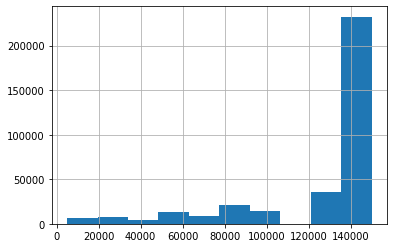

In [47]:
df['kilometer'].hist()

In [48]:
df['kilometer'].describe()

count    344203.000000
mean     128798.877407
std       37033.159481
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

In [49]:
df['kilometer'].isna().sum()

0

На лицо явный перекос значений, такого распределения не может быть. Думаю оно связано, с ограничением сайта объявлений на максимально вводимое значения для пройденого километража, в нашем случае это 150 000 км. Очень жаль, что так получилось, потому что это важный признак для стоимости машины. Оставим его как есть.

#### not_repaired

In [50]:
df['not_repaired'].value_counts(dropna=False)

no     244190
NaN     65085
yes     34928
Name: not_repaired, dtype: int64

Пропуски в данном столбце точно ни как не получится заполнить, и так как признак категориальный, то расширим диапазон значений, заполнив пропуски значением `unknow`

In [51]:
df['not_repaired'] = df['not_repaired'].fillna('unknown')

#### number_of_pictures

In [52]:
df['number_of_pictures'].value_counts(dropna=False)

0    344203
Name: number_of_pictures, dtype: int64

Удалим данный столбец, так как ни какой полезной информации он не несет

In [53]:
df = df.drop(['number_of_pictures'], axis=1)

#### price

In [54]:
df['price'].describe()

count    344203.000000
mean       4481.432503
std        4526.093329
min           0.000000
25%        1100.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

Нулевой цены или около нулевой не может быть, проверим данные строки

In [55]:
df[df['price'] <= 100]['price'].count() / len(df['price'])

0.03525535802999974

3,5% в рамках допустимого, поэтому предлагается удалить эти данные

In [56]:
df = df.drop(index=df[df['price'] <= 100]['price'].index).reset_index(drop=True)

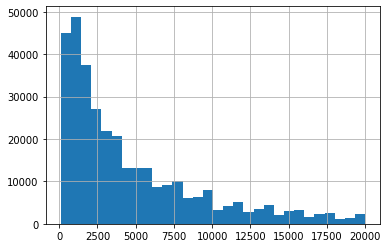

In [57]:
df['price'].hist(bins=30)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332068 entries, 0 to 332067
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   price              332068 non-null  int64         
 1   vehicle_type       332068 non-null  object        
 2   gearbox            332068 non-null  object        
 3   power              332068 non-null  int64         
 4   model              332068 non-null  object        
 5   kilometer          332068 non-null  int64         
 6   fuel_type          332068 non-null  object        
 7   brand              332068 non-null  object        
 8   not_repaired       332068 non-null  object        
 9   date_created       332068 non-null  datetime64[ns]
 10  registration_date  332068 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(6)
memory usage: 27.9+ MB


---

Последний шаг - проверим на дубликаты

In [59]:
df.duplicated().sum()

11657

In [60]:
df = df.drop_duplicates().reset_index(drop = True)

#### Вывод

Подготовили данные, а именно - удалили ненужные столбцы, объединили столбцы с датой, заполнили пропуски, исправили выбросы. Остались последние манипуляции по подготовке данных - это разбиение на трейн, тест выборки; масшатбирование количественных признаков, преобразование категориальных признаков.

### Подготовка данных для обучения

Так как в разные алгоритым будем подавать разные наборы данных, то обозначим их индексами 1 и 2. Данные с индексом 1 подготовим для алгоритма LinearRegression & RandomForest с индексом 2 для остальных.

In [61]:
df_1 = df.copy()
df_2 = df.copy()

#### Преобразование категориальных столбцов и столбцов Даты

In [62]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320411 entries, 0 to 320410
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   price              320411 non-null  int64         
 1   vehicle_type       320411 non-null  object        
 2   gearbox            320411 non-null  object        
 3   power              320411 non-null  int64         
 4   model              320411 non-null  object        
 5   kilometer          320411 non-null  int64         
 6   fuel_type          320411 non-null  object        
 7   brand              320411 non-null  object        
 8   not_repaired       320411 non-null  object        
 9   date_created       320411 non-null  datetime64[ns]
 10  registration_date  320411 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(6)
memory usage: 26.9+ MB


In [63]:
cat_data = ['vehicle_type','gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

Преобразуем категориальные признаки

In [64]:
df_1 = pd.get_dummies(data=df_1,columns=cat_data, drop_first=True)

In [65]:
df_2[cat_data] = df_2[cat_data].astype('category')

Так как столбцы с типом ДАТА нельзя напрямую подать в модели, поэтому преобразуем данные столбцы в численные значения, и масштабируем их вместе количественными столбцами

In [66]:
# Change data columns
temp_list = df_1['registration_date'].to_list()
temp_list = np.array(fa.datetimeToFloatyear(temp_list)) # for example, 2020-07-01 becomes 2020.49589041
df_1['registration_date'] = temp_list
# Change data columns
temp_list = df_2['registration_date'].to_list()
temp_list = np.array(fa.datetimeToFloatyear(temp_list)) # for example, 2020-07-01 becomes 2020.49589041
df_2['registration_date'] = temp_list

In [67]:
# Change data columns
temp_list = df_1['date_created'].to_list()
temp_list = np.array(fa.datetimeToFloatyear(temp_list)) # for example, 2020-07-01 becomes 2020.49589041
df_1['date_created'] = temp_list
# Change data columns
temp_list = df_2['date_created'].to_list()
temp_list = np.array(fa.datetimeToFloatyear(temp_list)) # for example, 2020-07-01 becomes 2020.49589041
df_2['date_created'] = temp_list

In [68]:
num_data = ['power','kilometer', 'date_created', 'registration_date']

In [69]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320411 entries, 0 to 320410
Columns: 309 entries, price to not_repaired_yes
dtypes: float64(2), int64(3), uint8(304)
memory usage: 105.1 MB


In [70]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320411 entries, 0 to 320410
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              320411 non-null  int64   
 1   vehicle_type       320411 non-null  category
 2   gearbox            320411 non-null  category
 3   power              320411 non-null  int64   
 4   model              320411 non-null  category
 5   kilometer          320411 non-null  int64   
 6   fuel_type          320411 non-null  category
 7   brand              320411 non-null  category
 8   not_repaired       320411 non-null  category
 9   date_created       320411 non-null  float64 
 10  registration_date  320411 non-null  float64 
dtypes: category(6), float64(2), int64(3)
memory usage: 14.4 MB


#### Разбиение на подвыборки

Разобьем выборку на две части: тренировочную (75%) и тестовую (25%)

In [71]:
df_train_1, df_test_1 = train_test_split(df_1, test_size=0.25, random_state=101)
df_train_2, df_test_2 = train_test_split(df_2, test_size=0.25, random_state=101)

Проверка

In [72]:
display(df_train_1.shape)
display(df_test_1.shape)
display(df_train_2.shape)
display(df_test_2.shape)

(240308, 309)

(80103, 309)

(240308, 11)

(80103, 11)

Данные для обучения

In [73]:
features_train_1 = df_train_1.drop(['price'], axis=1)
target_train_1 = df_train_1['price']
features_train_2 = df_train_2.drop(['price'], axis=1)
target_train_2 = df_train_2['price']

Данные для тестирования

In [74]:
features_test_1 = df_test_1.drop(['price'], axis=1)
target_test_1 = df_test_1['price']
features_test_2 = df_test_2.drop(['price'], axis=1)
target_test_2 = df_test_2['price']

#### Преобразование количественных столбцов

Масштабируем количественные признаки

In [75]:
scaler = StandardScaler()
scaler.fit(features_train_1[num_data]) 
features_train_1[num_data] = scaler.transform(features_train_1[num_data])
features_test_1[num_data] = scaler.transform(features_test_1[num_data])
features_train_2[num_data] = scaler.transform(features_train_2[num_data])
features_test_2[num_data] = scaler.transform(features_test_2[num_data])

### Вывод

Произвели полную подготовку данных для обучения, теперь перейдем к поиску лучшей и быстрейшей модели

## Обучение моделей

Будем рассматривать 4 вида моделей: LinearRegression, RandomForest, CatBoost, LightGBM. В качестве метрики будет **RMSE**. Сначала с помощью **GridSearchCV** найдем оптимальные параметры, выбирем лучшие модели и далее будем оценивать их по показетелю метрики и потраченному времени на обучение и предсказание.

Так как в самой простой модели LinearRegression, нет параметров для настройки, их поиск осуществлять не будем.

### Модель - RandomForest

In [76]:
result_df = pd.DataFrame(columns=['RMSE', 'R2'])
result_df.index.name='name_ml'

In [77]:
%%time
#Время выполнения ячеки около 12 минут
tuned_parameters = {"n_estimators": list(range(60,101,20)), 
                    "max_depth"   : list(range(2,5,1))}

scoring = ('neg_root_mean_squared_error')
rf_model = RandomForestRegressor(random_state=101)

rand_forest = GridSearchCV(rf_model, param_grid=tuned_parameters, scoring=scoring, cv=2, n_jobs=-1)
rand_forest.fit(features_train_1, target_train_1)
print("Best parameters set found on development set:")
print(rand_forest.best_params_)
print('')
print('***'*30)
rand_pred = rand_forest.predict(features_test_1)
result_df.loc['RandomForest'] = [round(mean_squared_error(target_test_1, rand_pred, squared=False), 2), 
                                 round(r2_score(target_test_1, rand_pred), 2)]
display(result_df)

Best parameters set found on development set:
{'max_depth': 4, 'n_estimators': 60}

******************************************************************************************


,RMSE,R2
name_ml,,
RandomForest,2643.12,0.66


CPU times: user 1min 34s, sys: 1.07 s, total: 1min 35s
Wall time: 11min 44s


Дополниельно построим график "Зависимости времени обучения от параметров модели"

In [78]:
RF_cv_results = pd.DataFrame(data=[rand_forest.cv_results_['mean_fit_time'],
                                   rand_forest.cv_results_['mean_score_time'],
                                   rand_forest.cv_results_['param_max_depth'].data,
                                   rand_forest.cv_results_['param_n_estimators'].data]).T
RF_cv_results.columns = ['Ср.время обучения', 'Ср.время предсказания', 'Парам. Глубины', 'Кол-во деревьев']
RF_cv_results

,Ср.время обучения,Ср.время предсказания,Парам. Глубины,Кол-во деревьев
0,31.631311,0.434898,2.0,60.0
1,41.907028,0.488762,2.0,80.0
2,51.809744,0.600171,2.0,100.0
3,48.703421,0.545274,3.0,60.0
4,66.613106,0.623325,3.0,80.0
5,83.015251,0.767823,3.0,100.0
6,69.324884,0.553742,4.0,60.0
7,97.968976,0.681703,4.0,80.0
8,115.648988,0.900402,4.0,100.0


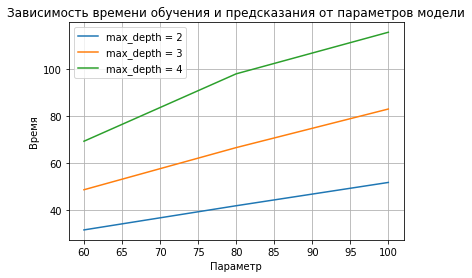

In [79]:
plt.title('Зависимость времени обучения и предсказания от параметров модели')
plt.xlabel('Параметр')
plt.ylabel('Время')
x=list(range(60,101,20))
y1=list(RF_cv_results['Ср.время обучения'][:3])
y2=list(RF_cv_results['Ср.время обучения'][3:6])
y3=list(RF_cv_results['Ср.время обучения'][6:])
plt.plot(x,y1, label='max_depth = 2')
plt.plot(x,y2, label='max_depth = 3')
plt.plot(x,y3, label='max_depth = 4')
plt.legend(frameon=True)
plt.grid()
plt.show()

Как видно из графика с увеличением количества деревьев время обучения увеличивается, а чем больше глубина, тем круче наклон прямой, то есть время обучения еще быстрее увеличивается.

### Модель - CatBoost

Выделем категориальные признаки

In [80]:
%%time
#Время выполнения ячеки около 2 минут
tuned_parameters = {'depth'         : [6,8,10],
                    'iterations'    : list(range(60,101,20))
                   }

cat_model = cb.CatBoostRegressor(random_seed=101, 
                                 early_stopping_rounds=20, 
                                 loss_function = 'RMSE',
                                 cat_features = cat_data,
                                 silent=True)

CBR = GridSearchCV(cat_model, param_grid=tuned_parameters, cv=2, n_jobs=-1)
CBR.fit(features_train_2, target_train_2, eval_set=(features_test_2, target_test_2))

print("Best parameters set found on development set:")
print(CBR.best_params_)
print('')
print('***'*30)
cat_pred = CBR.predict(features_test_2)
result_df.loc['CatBoost'] = [round(mean_squared_error(target_test_2, cat_pred, squared=False), 2), 
                                 round(r2_score(target_test_2, cat_pred), 2)]
display(result_df)

Best parameters set found on development set:
{'depth': 10, 'iterations': 100}

******************************************************************************************


,RMSE,R2
name_ml,,
RandomForest,2643.12,0.66
CatBoost,1623.51,0.87


CPU times: user 33.4 s, sys: 784 ms, total: 34.2 s
Wall time: 2min 5s


Дополниельно построим график "Зависимости времени обучения от параметров модели"

In [81]:
CBR_cv_results = pd.DataFrame(data=[CBR.cv_results_['mean_fit_time'],
                                   CBR.cv_results_['mean_score_time'],
                                   CBR.cv_results_['param_depth'].data,
                                   CBR.cv_results_['param_iterations'].data]).T
CBR_cv_results.columns = ['Ср.время обучения', 'Ср.время предсказания', 'Парам. Глубины', 'Кол-во деревьев']
CBR_cv_results

,Ср.время обучения,Ср.время предсказания,Парам. Глубины,Кол-во деревьев
0,6.719495,0.196237,6.0,60.0
1,8.401988,0.203418,6.0,80.0
2,10.350692,0.214130,6.0,100.0
3,8.850306,0.211669,8.0,60.0
4,10.969969,0.227143,8.0,80.0
5,14.047703,0.220290,8.0,100.0
6,11.582977,0.241197,10.0,60.0
7,14.997450,0.239998,10.0,80.0
8,18.812773,0.206936,10.0,100.0


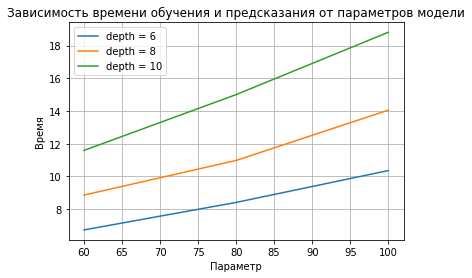

In [82]:
plt.title('Зависимость времени обучения и предсказания от параметров модели')
plt.xlabel('Параметр')
plt.ylabel('Время')
x=list(range(60,101,20))
y1=list(CBR_cv_results['Ср.время обучения'][:3])
y2=list(CBR_cv_results['Ср.время обучения'][3:6])
y3=list(CBR_cv_results['Ср.время обучения'][6:])
plt.plot(x,y1, label='depth = 6')
plt.plot(x,y2, label='depth = 8')
plt.plot(x,y3, label='depth = 10')
plt.legend(frameon=True)
plt.grid()
plt.show()

По данной модели можно сделать аналогичные выводы, за исключением того что нет явного различия в углах наклона прямых. То есть время обучения для различной глубины деревьев будет одинаково расти для одних и тех же значений количества деревьев. Плюс на данном графике видно, что время обучение в два раза меньше по сравнению с моделью Random Forest.

### Модель - LightGBM

In [83]:
%%time
#Время выполнения ячеки около 1 минуты
tuned_parameters = {'max_depth'         : [6,8,10],
                    'n_estimators'      : list(range(60,101,20))
                   }

lgb_model = lgb.LGBMRegressor(metric ='rmse', 
                              random_state=101,
                              feature_fraction=0.8, #LightGBM will select 80% of features before training each tree
                              bagging_fraction=0.8, #like feature_fraction, but this will randomly select part of data 
                                                    #without resampling
                              bagging_freq=5)       #frequency for bagging, 0 means disable bagging; k means perform 
                                                    #bagging at every k iteration. Every k-th iteration, LightGBM will 
                                                    #randomly select bagging_fraction * 100 % of the data to use for the 
                                                    #next k iterations

LGB = GridSearchCV(lgb_model, param_grid=tuned_parameters, cv=2, n_jobs=-1)
LGB.fit(features_train_2, target_train_2)

print("Best parameters set found on development set:")
print(LGB.best_params_)
print('')
print('***'*30)
lgb_pred = LGB.predict(features_test_2)
result_df.loc['LGB'] = [round(mean_squared_error(target_test_2, lgb_pred, squared=False), 2), 
                                 round(r2_score(target_test_2, lgb_pred), 2)]
display(result_df)

Best parameters set found on development set:
{'max_depth': 10, 'n_estimators': 100}

******************************************************************************************


,RMSE,R2
name_ml,,
RandomForest,2643.12,0.66
CatBoost,1623.51,0.87
LGB,1636.76,0.87


CPU times: user 7.46 s, sys: 223 ms, total: 7.68 s
Wall time: 36.5 s


Дополниельно построим график "Зависимости времени обучения от параметров модели"

In [84]:
LGB_cv_results = pd.DataFrame(data=[LGB.cv_results_['mean_fit_time'],
                                   LGB.cv_results_['mean_score_time'],
                                   LGB.cv_results_['param_max_depth'].data,
                                   LGB.cv_results_['param_n_estimators'].data]).T
LGB_cv_results.columns = ['Ср.время обучения', 'Ср.время предсказания', 'Парам. Глубины', 'Кол-во деревьев']
LGB_cv_results

,Ср.время обучения,Ср.время предсказания,Парам. Глубины,Кол-во деревьев
0,1.837874,0.906518,6.0,60.0
1,2.198384,1.205790,6.0,80.0
2,2.607201,1.482062,6.0,100.0
3,1.849121,0.971029,8.0,60.0
4,2.359701,1.296555,8.0,80.0
5,2.715163,1.616722,8.0,100.0
6,1.871435,0.983496,10.0,60.0
7,2.414750,1.301771,10.0,80.0
8,2.741692,1.512269,10.0,100.0


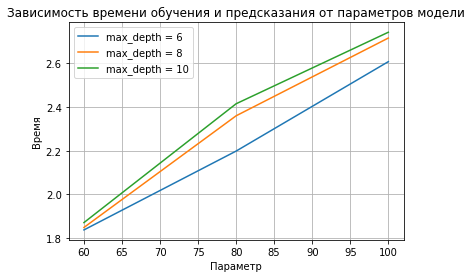

In [85]:
plt.title('Зависимость времени обучения и предсказания от параметров модели')
plt.xlabel('Параметр')
plt.ylabel('Время')
x=list(range(60,101,20))
y1=list(LGB_cv_results['Ср.время обучения'][:3])
y2=list(LGB_cv_results['Ср.время обучения'][3:6])
y3=list(LGB_cv_results['Ср.время обучения'][6:])
plt.plot(x,y1, label='max_depth = 6')
plt.plot(x,y2, label='max_depth = 8')
plt.plot(x,y3, label='max_depth = 10')
plt.legend(frameon=True)
plt.grid()
plt.show()

Полученные данные довольно интересны, но их нельзя в прямую сравнить с прошлыми данными, так как "из коробочки" данный алгоритм очень долго считает(более получаса, дальше терпение кончилось). Поэтому были задействованы параметры для ускорения расчетов, соответственно "турбо-режим" для Catboost применен не был.

### Вывод

Посмотрим на наши значения метрик для всех алгоритмов и построим график

In [86]:
result_df

,RMSE,R2
name_ml,,
RandomForest,2643.12,0.66
CatBoost,1623.51,0.87
LGB,1636.76,0.87


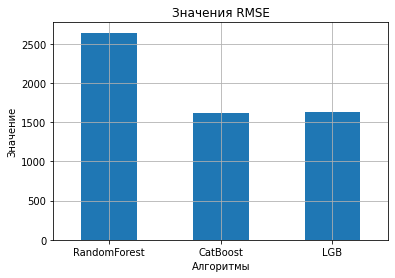

In [87]:
result_df['RMSE'].plot(kind='bar')
plt.title('Значения RMSE')
plt.xlabel('Алгоритмы')
plt.ylabel('Значение')
plt.xticks(range(len(result_df['RMSE'])), labels=result_df.index, rotation=0)
plt.grid()
plt.show()

Как видно из графика лучшее значении метрики у Catboost.

## Анализ моделей

Теперь используем лучшие виды моделей из прошлого пункта, для определения лучшей модели для данного заказчика. Будем смотреть на время обучения, предсказания таргета и на значение метрики

In [88]:
# Сформируем перечень моделей, которые будут обучены
models = [
    ('Linear Regression', 1, LinearRegression()),
    ('RandomForest', 1, rand_forest.best_estimator_),
    ('CatBoost', 2, CBR.best_estimator_),
    ('LightGBM', 2, LGB.best_estimator_),
    ('Dummy', 1, DummyRegressor(strategy="median"))
]

# Итоговая таблица
results = pd.DataFrame(columns=['Обучение (сек)', 'Предсказание (сек)', 'Среднее RMSE на валидации', 'Среднее R2 на валидации'])
results.index.name = 'Модель'

# Проведем выбор лучшей модели
for name, data, model in tqdm(models):
    if data == 1:
        features_train = features_train_1
        target_train = target_train_1
        features_test = features_test_1
        target_test = target_test_1
    else:
        features_train = features_train_2
        target_train = target_train_2
        features_test = features_test_2
        target_test = target_test_2
    
    start_time = time.time()
    model.fit(features_train, target_train)
    time_1 = time.time() - start_time
    
    start_time = time.time()
    predict = model.predict(features_test)
    time_2 = time.time() - start_time
    
    results.loc[name]=[time_1, time_2, mean_squared_error(target_test, predict, squared=False), r2_score(target_test, predict)]
    
    if name == "Dummy": # Сравнения с болванкой
        dummy = DummyRegressor(strategy="median")
        
        start_time = time.time()
        dummy.fit(features_train, target_train)
        time_1 = time.time() - start_time
        
        start_time = time.time()
        predict = dummy.predict(features_test)
        time_2 = time.time() - start_time
        
        results.loc[name]=[time_1, time_2, mean_squared_error(target_test, predict, squared=False), r2_score(target_test, predict)]

# Выведем результаты
display(results)

  0%|          | 0/5 [00:00<?, ?it/s]

,Обучение (сек),Предсказание (сек),Среднее RMSE на валидации,Среднее R2 на валидации
Модель,,,,
Linear Regression,8.505829,0.117572,2611.044717,0.669351
RandomForest,102.084048,0.278028,2643.115564,0.661179
CatBoost,23.699039,0.189571,1621.313639,0.872511
LightGBM,4.328901,0.486665,1636.764690,0.870070
Dummy,0.006277,0.000516,4849.356081,-0.140529


---

## Вывод

В ходе работы было выполнено:
- подготовка и очистка данных
- преобразование и подготовка данных для обучения моделей
- подбор гиперпараметров моделей и построение графиков зависимостей времени обучения от гиперпараметров моделей
- произведено сравнение лучших моделей между собой, а так же с сравнение их с константной моделью
- выявлена лучшая модель **Catboost**